In [155]:
# imports
import pandas as pd
import os
from prettytable import PrettyTable
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

In [156]:
# helper functions
durations = []
completeness_check = {}

def extract_duration(df, setting):
    # print(setting)
    if "duration_in_seconds" in df.columns:
        duration_col = "duration_in_seconds"
        last_index = df[duration_col].last_valid_index()
        duration = df.at[last_index, duration_col]
        duration_col = setting + "_" + duration_col # add setting to compare better
        if duration >= 2400: # higher than 40 min
            print(duration_col + " with duration " + str(duration) + " in minutes: ---" + "{:.2f}".format(duration/60) + "--- and in hours: " + "{:.2f}".format((duration/60)/60))
        durations.append(duration)

def ignore_setting(setting, to_be_ignored):
    if any(substring in setting for substring in to_be_ignored):
        return True

    if "ppo" not in setting and "dqn" not in setting:
        return True
    
    # document market occurences to check later if anything is missing
    document_setting = setting
    if "-am" in setting or "-sm" in setting:
        document_setting = setting.split("-am")[0]+"-am" if "-am" in setting else setting.split("-sm")[0]+"-sm"
    if document_setting in completeness_check:
        completeness_check[document_setting] += 1
    else:
        completeness_check[document_setting] = 1


    return False

def print_info():
    print("overall runtime: {:.2f}".format((sum(durations)/60)/60) + " ({:.2f} min)".format((sum(durations)/60)) +" overall runs: " + str(len(durations)))
    print("mean runtime in minutes: {:.2f}".format((sum(durations)/len(durations))/60))

    # count overall settings to check if something is missing
    # standard am, goal, no debt, no reset and goal with no debt and goal with no reset
    expected_am_settings = 6
    # standard sm, goal, no reset and goal with no reset
    expected_sm_settings = 4 
    # 3 for base compositions (coop, mixed, competitive) added with their market extensions and the  2 for difference reward and one agent execution ("1-"...) 
    overall_expectation_count = 3 + 3 * expected_am_settings+ 3 * expected_sm_settings + 2
    if len(durations) != overall_expectation_count:
        print("Overall count is off: expected " + str(overall_expectation_count) + " but counted " + str(len(durations)))

    print(completeness_check)

    # and count market settings to specify where to look
    for setting, occurences in completeness_check.items():
        if "am" in setting and occurences != expected_am_settings:
            print("Occurences for base setting "+ setting + " are off: expected "+ str(expected_am_settings)+ " but counted "+ str(occurences) )
        elif "sm" in setting and occurences != expected_sm_settings:
            print("Occurences for base setting "+ setting + " are off: expected "+ str(expected_sm_settings)+ " but counted "+ str(occurences) )

In [157]:
# read all storage folders to extract training info, i.e. markets and save it to envs
#TODO normalize rewards to "reward_summary"
df_keys = ["reward_summary", "mean_grid_coloration_percentage", "mean_num_reset_fields", "fully_colored", "mean_num_frames_per_episode", "mean_trades"]
ignored_setting_substrings = [] # i.e. ["dqn_comparisons"]

try:
    dqn_folders = os.listdir('./dqn') 
except(FileNotFoundError):
    dqn_folders = []

try:
    ppo_folders = os.listdir('./ppo') 
except(FileNotFoundError):
    ppo_folders = []

training_folders = ppo_folders + dqn_folders

# while iterating create a wideform dataframe of all csv files
df_settings_dict = {}

for folder in training_folders:
    if ignore_setting(folder, ignored_setting_substrings):
        continue

    # read csv file (if it exists)
    try:
        algo = "ppo" if "ppo" in folder else "dqn"
        df_settings_dict[folder] = pd.read_csv('./'+algo +"/"+folder+'/log.csv')
    except:
        continue
    
    # extract durations
    extract_duration(df_settings_dict[folder], folder)

    # only extract columns that are substrings of df_keys (only those are of interest here) 
    cols_of_interest = [col for col in df_settings_dict[folder].columns if any(df_key in col for df_key in df_keys) or "frames" in col or "reward" in col]
    df_settings_dict[folder] = df_settings_dict[folder].filter(items = cols_of_interest)  

    # add setting to the df columns
    df_settings_dict[folder].columns = [folder + "_" + str(col) for col in df_settings_dict[folder].columns if any(df_key in col for df_key in df_keys) or "frames" in col or "reward" in col]

# join all dataframes (one per setting)
all_data_df = pd.concat([df for df in df_settings_dict.values()], axis=1)
print_info()

2-dqn-mixed-am-no-debt_duration_in_seconds with duration 2688 in minutes: ---44.80--- and in hours: 0.75
2-dqn-dr_duration_in_seconds with duration 16187 in minutes: ---269.78--- and in hours: 4.50
2-dqn-sm-no-reset_duration_in_seconds with duration 2521 in minutes: ---42.02--- and in hours: 0.70
2-dqn-mixed-sm-goal-no-reset_duration_in_seconds with duration 2420 in minutes: ---40.33--- and in hours: 0.67
2-dqn-competitive-am-no-debt_duration_in_seconds with duration 2593 in minutes: ---43.22--- and in hours: 0.72
2-dqn-sm-goal-no-reset_duration_in_seconds with duration 2445 in minutes: ---40.75--- and in hours: 0.68
overall runtime: 26.49 (1589.25 min) overall runs: 70
mean runtime in minutes: 22.70
Overall count is off: expected 35 but counted 70
{'2-ppo-competitive-am': 6, '2-ppo-mixed-sm': 4, '2-ppo-mixed-am': 6, '2-ppo-competitive-sm': 4, '2-ppo-am': 6, '2-ppo-mixed': 1, '2-ppo-competitive': 1, '2-ppo-dr': 1, '1-ppo': 1, '2-ppo-sm': 4, '2-ppo': 1, '2-dqn-competitive-sm': 4, '2-dqn

In [187]:
# Plot functions

def beautify_legend(plot_name, key, size):
    # beatify plot legend labels
    _, labels = plot_name.get_legend_handles_labels()
    for index, label in enumerate(labels):
        # if "-dr" in label:
        #     new_label = "difference reward"
        # else:
        new_label = label.split(key)[0]
        new_label = " ".join(new_label.split("_"))
        new_label = " ".join(new_label.split("-"))
        labels[index] = new_label.strip()
    plot_name.legend(handles=plot_name.legend_.legendHandles,labels=labels, fontsize=size)

def normalize_rewards(setting_names):
    df = all_data_df.copy()
    for setting in setting_names:
        reward_cols = [col for col in df.columns if setting == col.split("_")[0] and "mean_reward" in col]
        # normalize reward values!
        new_col = setting+"_reward_summary"
        df[new_col] = df[reward_cols].sum(axis='columns')
        col_min = df[new_col].min()
        col_max = df[new_col].max()
        df[new_col] = (df[new_col]-col_min)/(col_max-col_min)
    return df

def recalculate_rewards(setting_names):
    df = all_data_df.copy()
    for setting in setting_names:
        reward_cols = [col for col in df.columns if setting == col.split("_")[0] and "mean_reward" in col]
        new_col = setting+"_reward_summary"
        if "mixed" in setting:
            df[new_col] = df[reward_cols].round(2).sum(axis='columns').round(2)
        else: # coop has always the same reward across agents
            df[new_col] = df[reward_cols].mean(axis=1).round(2)
    return df

def form_data(df, stats_setting_names, key):
    frames_col = [col for col in df.columns if any(setting == col.split("_")[0] for setting in stats_setting_names) and "frames" in col][0]
    data = df[[col for col in df.columns if frames_col == col or any(setting == col.split("_")[0] for setting in stats_setting_names) and key in col]]
    long_data = data.melt(id_vars=[frames_col], var_name="setting")
    long_data.rename(columns={frames_col:'frames'}, inplace=True)
    long_data = long_data[long_data['setting'].str.contains(key, na = False)]
    return long_data

def improve_plot(plot, key, label, title, subplot=None, min_value=0, max_value=None, legend_font_size=10, title_font_size=15, label_interval=None):
     # beatify plot legend labels
    beautify_legend(plot, key, legend_font_size)

    if subplot:
        subplot.set_ylabel(label, fontsize=legend_font_size)
        subplot.set_xlabel("frames", fontsize=legend_font_size)
        subplot.set_title(title, fontsize = title_font_size)

    # show every label_interval x label if set
    if label_interval:
        [x_label.set_visible(False) for (index,x_label) in enumerate(plot.xaxis.get_ticklabels()) if index % label_interval != 0]
    
    # add some space to top/bottom of last y values 
    space = 0.05 if max_value < 10 else 1

    # set min/max values to be equal for better comparisons 
    if min_value < 0:
        plot.set_ylim(bottom=min_value-space)
    else:
        plot.set_ylim(bottom=-space)
        
    if "reward" in key:
        plot.set_ylim(top=1.2)
    elif "grid_coloration" in key:
        plot.set_ylim(top=1.05)
    elif not "trade" in label:
        plot.set_ylim(top=max_value+space)

def create_double_multiplot (top_stats_settings, top_plot_title, worst_stats_settings, worst_plot_title):
    top_df = recalculate_rewards(top_stats_settings)
    worst_df = recalculate_rewards(worst_stats_settings)
    
    sns.set_theme()
    max_col = 4
    max_row = 4
    col = 0
    row = 0

    # every key is shown in one plot (rewards are shown in two as an exception)
    for key in df_keys:
        if row >= max_row or (row == 0 and col == 0): 
            row = 0
            fig = plt.figure(constrained_layout=True, figsize=(25, 23))
            grid = plt.GridSpec(max_row, max_col, hspace=0.3)

        y_label = " ".join(key.split("_"))
        top_data = form_data(top_df, top_stats_settings, key)
        worst_data = form_data(worst_df, worst_stats_settings, key)

        top_hue_order = [setting+"_"+key for setting in top_stats_settings]
        worst_hue_order = [setting+"_"+key for setting in worst_stats_settings]

        min_value = top_data["value"].min() if top_data["value"].min() <= worst_data["value"].min() else worst_data["value"].min()
        max_value = top_data["value"].max() if top_data["value"].max() >= worst_data["value"].max() else worst_data["value"].max()
        
        if "reward" in key:
            n_entry = 5
            t_reward_subplot = fig.add_subplot(grid[row:1, 0:2])
            t_reward_plot = sns.barplot(data=top_data.iloc[::n_entry, :], x="frames", y="value", hue="setting", hue_order=top_hue_order)
            improve_plot(t_reward_plot, key, y_label, top_plot_title, subplot=t_reward_subplot, min_value=min_value, max_value=max_value, label_interval=1)

            w_reward_subplot = fig.add_subplot(grid[row:1, 2:max_col])
            w_reward_plot = sns.barplot(data=worst_data.iloc[::n_entry, :], x="frames", y="value", hue="setting", hue_order=worst_hue_order)
            improve_plot(w_reward_plot,  key, y_label, worst_plot_title, subplot=w_reward_subplot,min_value=min_value, max_value=max_value, label_interval=1)

            row += 1
            col = 0

        t_subplot = fig.add_subplot(grid[row, col])
        t_plot = sns.lineplot(data=top_data, x="frames", legend="brief", y="value", hue_order=top_hue_order, hue="setting", linewidth=2) # style="setting"
        improve_plot(t_plot, key, y_label, y_label, subplot=t_subplot, min_value=min_value, max_value=max_value)
        
        w_subplot = fig.add_subplot(grid[row, col+2])
        w_plot = sns.lineplot(data=worst_data, x="frames", legend="brief", y="value", hue_order=worst_hue_order, hue="setting", linewidth=2) # style="setting"
        improve_plot(w_plot, key, y_label, y_label, subplot=w_subplot, min_value=min_value, max_value=max_value)

        col += 1

        if col >= 2:
            row += 1
            col = 0

def print_double_multiplot(stats):
    for index, (title, settings) in enumerate(stats.items()):
        if index % 2 != 0:
            # skip odds, since top and worst settings are compared side by side in one go in double plot
            continue
        worst_title = "Worst " + title.split(' ', 1)[1]
        create_double_multiplot(settings, title, stats[worst_title], worst_title)

def print_simple_plot(stats, key, title=None, labelsize=18, titlesize=20):
    stats_df = recalculate_rewards(stats)

    y_label = " ".join(key.split("_"))
    title = y_label if title is None else title
    stats_data = form_data(stats_df, stats, key)
    hue_order = [setting+"_"+key for setting in stats]

    min_value = stats_data["value"].min()
    max_value = stats_data["value"].max()


    fig, ax = plt.subplots(figsize=(15, 8)) #constrained_layout=True, figsize=(15, 8)
    plt.rc('axes', labelsize=labelsize)

    ax.tick_params(axis='both', which='major', labelsize=labelsize)
    ax.tick_params(axis='both', which='minor', labelsize=labelsize)
    plot = sns.lineplot(data=stats_data, x="frames", legend="brief", y="value", hue_order=hue_order, hue="setting", linewidth=2) # style="setting"
    improve_plot(plot, key, y_label, title, subplot=plot, min_value=min_value, max_value=max_value, legend_font_size=labelsize,title_font_size=titlesize)
        

In [159]:
# stats table functions

def get_all_stats(setting, keys, exclude):
    all_stats = {}
    for col in all_data_df.columns:
        if any(key in col for key in keys) and setting in col and not any(ignored_setting in col for ignored_setting in exclude):
            for key in keys:
                if key in col and setting in col:
                    stats_key = setting+"|"+key

                    if stats_key not in all_stats:
                        all_stats[stats_key] = {}
                    
                    if "grid_coloration" in key:
                        # calculate mean
                        all_stats[stats_key][col] = all_data_df[col].mean()
                    elif "reward" not in key:
                        all_stats[stats_key][col] = sum(all_data_df[col]) #sum(all_data_df[col][all_data_df[col].notna()])
    
    #  agent specific calculations
    if any("reward" in key for key in keys):
        #iterate all settings
        for training_folder in training_folders:
            if setting in training_folder and not any(ignored_setting in training_folder for ignored_setting in exclude):
                reward_cols = [col for col in all_data_df.columns if training_folder == col.split("_")[0] and "mean_reward" in col]
                col_name = reward_cols[0].split("_agent")[0]
                if "mixed" in training_folder:
                    all_stats[stats_key][col_name] = all_data_df[reward_cols].round(2).sum(axis='columns').mean()
                else: # coop has always the same reward across agents
                    all_stats[stats_key][col_name] = all_data_df[reward_cols].max(axis=1).mean()
    
    return all_stats

def get_top_worst_settings(keys, setting, stats_amount=10, exclude=[]):
    all_stats = get_all_stats(setting, keys, exclude)

    results = []
    table_headers = []
    df_cols = {}
    for stat, entries in all_stats.items():
        formatted_table_header = " ".join(stat.split("_")).split("|")[1]
        top_header = "Top " + formatted_table_header
        worst_header = "Worst " + formatted_table_header
        if top_header not in df_cols:
            df_cols[top_header] = [] 
        if worst_header not in df_cols:
            df_cols[worst_header] = [] 
            
        table_headers.append(top_header)
        table_headers.append(worst_header)
        # Top scores
        top_keys = sorted(entries, key=entries.get, reverse=True)[:stats_amount]
        results.append(top_keys)
        results.append([all_stats[stat][top_key] for top_key in top_keys])
        df_cols[top_header] = [top_key.split("_")[0] for top_key in top_keys]
        # Worst scores
        worst_keys = sorted(entries, key=entries.get, reverse=False)[:stats_amount]
        results.append(worst_keys)
        results.append([all_stats[stat][worst_key] for worst_key in worst_keys])
        df_cols[worst_header] = [worst_key.split("_")[0] for worst_key in worst_keys]

    return results, table_headers, df_cols

def get_stats(*args, print_table=False):
    stats, headers, df_cols = get_top_worst_settings(*args)

    stats_table = PrettyTable(['Position'] + headers)
    position = 1
    
    for row, _ in enumerate(stats[0]): # go through all entries
        row_entries = [position]
        # odd number contain values, even numbers contain settings
        # stats[1] contains values
        for column, stat in enumerate(stats):
            if column % 2 != 0:
                continue
            short_key = " ".join(stat[row].split("_")[0].split("-"))
            row_entries.append("{:0.1f}".format(stats[column+1][row])+" \n "+ short_key + " \n ")
        
        if row_entries:
            stats_table.add_row(row_entries)   
            position += 1
    
    if print_table:
        print(stats_table)
    
    return df_cols

In [160]:
# if nan values occur in stats table find out what setting might be the problem here
# print(all_data_df[all_data_df.columns[~all_data_df.isnull().any()]].columns)

# Stats Tables

+----------+-------------------+---------------------+
| Position | Top fully colored | Worst fully colored |
+----------+-------------------+---------------------+
|    1     |      2130.0       |        650.0        |
|          |       1 ppo       |        1 dqn        |
|          |                   |                     |
|    2     |       650.0       |       2130.0        |
|          |       1 dqn       |        1 ppo        |
|          |                   |                     |
+----------+-------------------+---------------------+


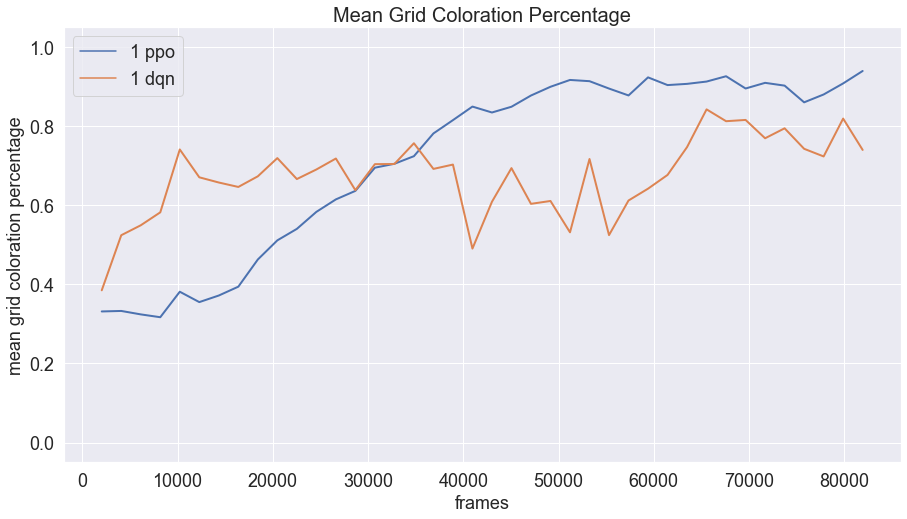

/opt/homebrew/Caskroom/miniforge/base/envs/python38/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


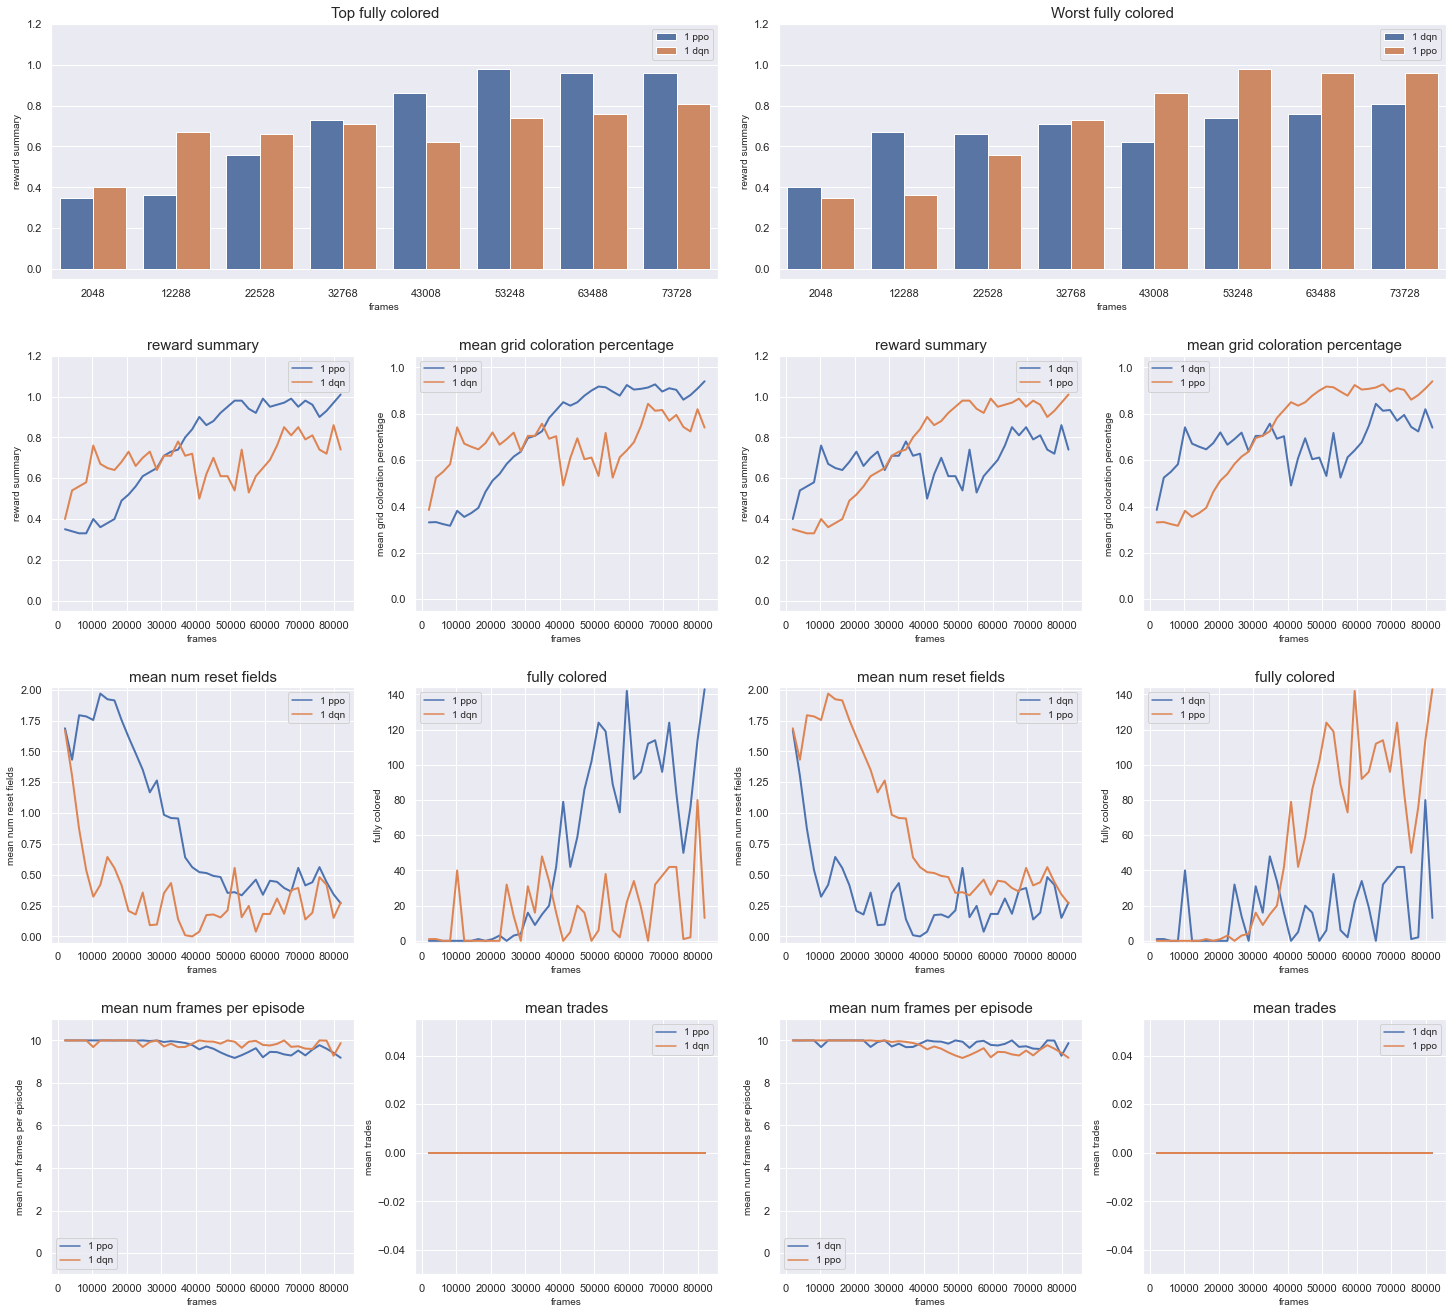

In [188]:
# only cooperation
one_agent_stats = get_stats(["fully_colored"], "1-", 3, ["mixed", "competitive"], print_table=True)

print_simple_plot(one_agent_stats['Top fully colored'], "mean_grid_coloration_percentage", "Mean Grid Coloration Percentage")
print_double_multiplot(one_agent_stats)


+----------+-------------------+--------------------------+
| Position | Top fully colored |   Worst fully colored    |
+----------+-------------------+--------------------------+
|    1     |       889.0       |          22.0            |
|          |      2 ppo dr     |  2 ppo sm goal no reset  |
|          |                   |                          |
|    2     |       125.0       |          23.0            |
|          |       2 ppo       |      2 ppo am goal       |
|          |                   |                          |
|    3     |       32.0        |          23.0            |
|          |   2 ppo sm goal   |  2 ppo am goal no reset  |
|          |                   |                          |
+----------+-------------------+--------------------------+
+----------+-------------------------+---------------------+
| Position |    Top fully colored    | Worst fully colored |
+----------+-------------------------+---------------------+
|    1     |         5949.0          

/opt/homebrew/Caskroom/miniforge/base/envs/python38/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


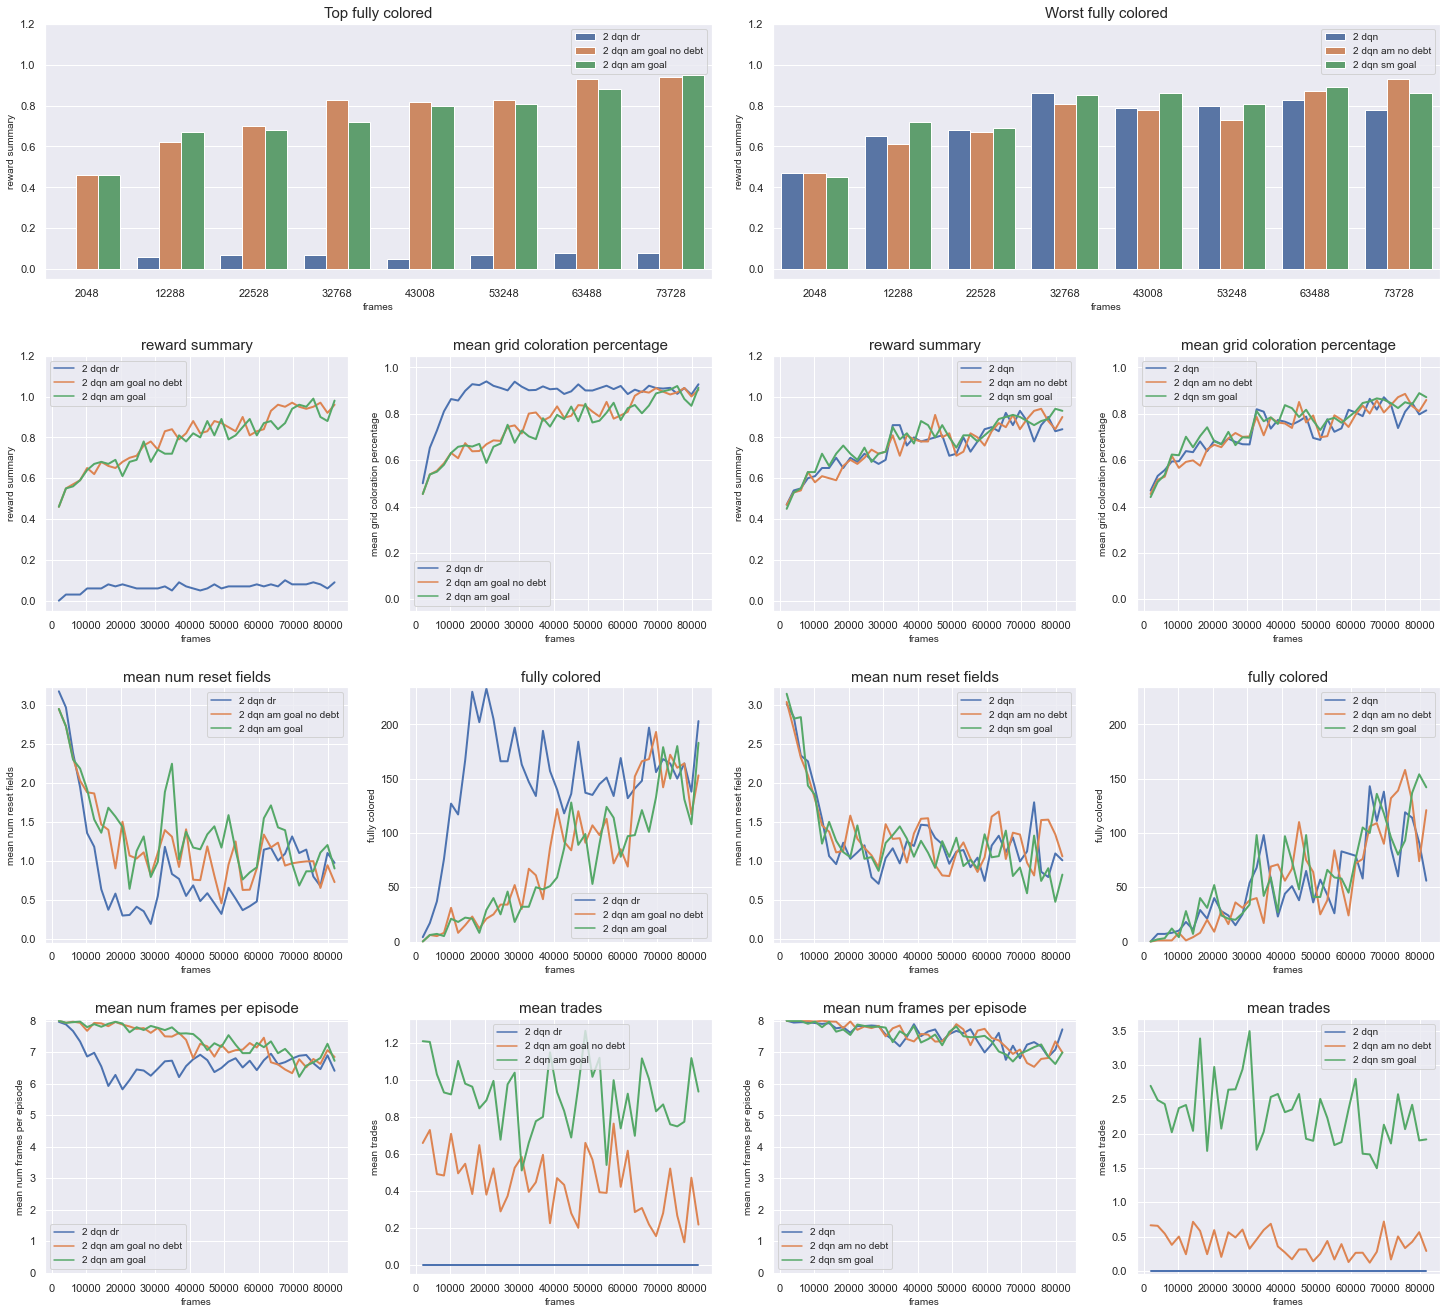

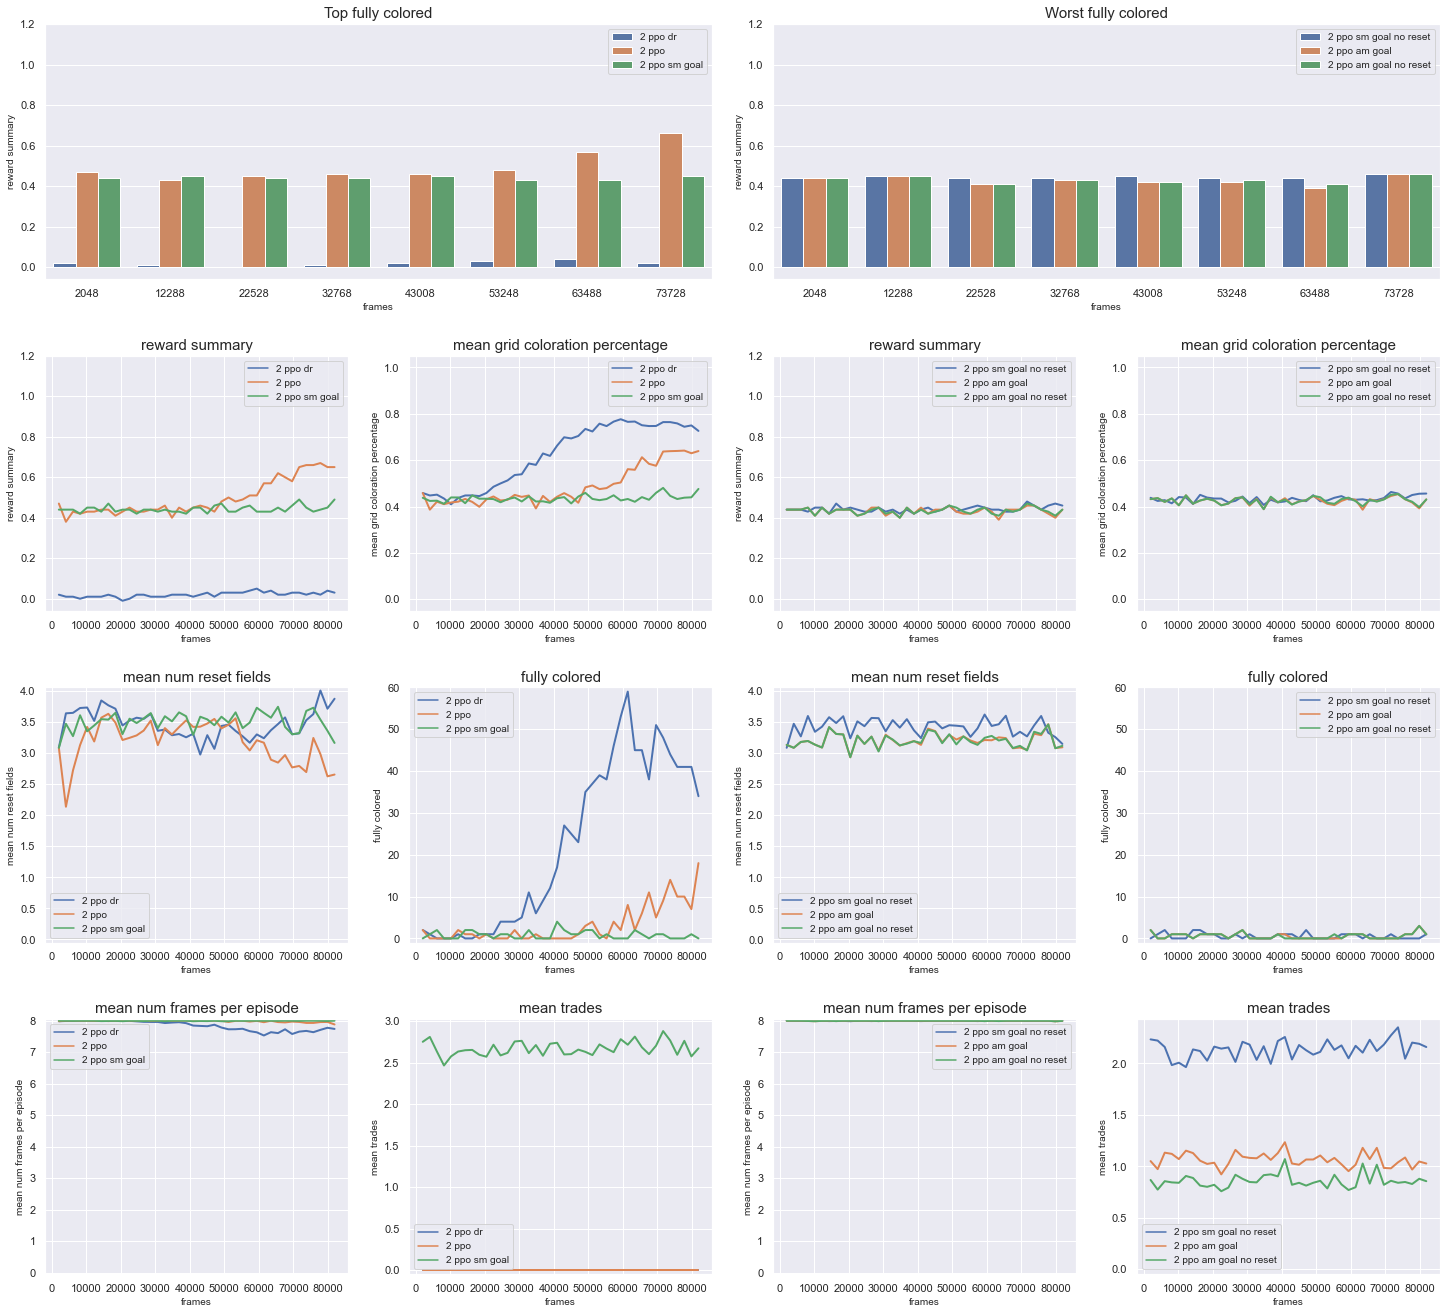

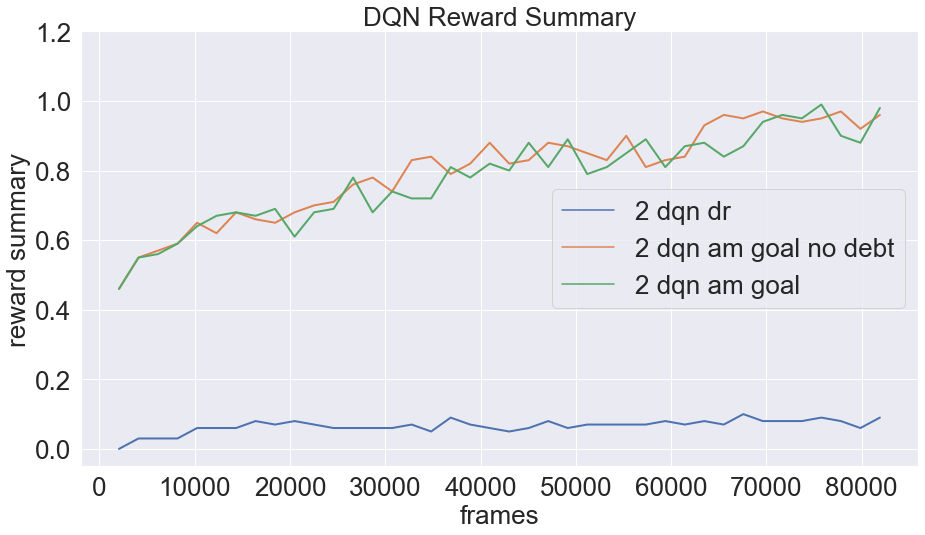

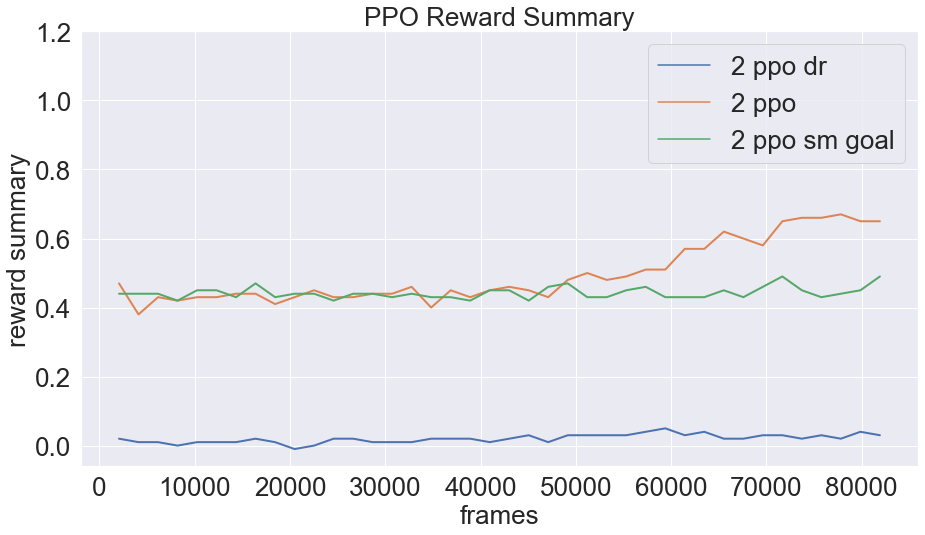

In [189]:
# only cooperation
ppo_coop_stats = get_stats(["fully_colored"], "2-ppo", 3, ["mixed", "competitive"], print_table=True)
dqn_coop_stats = get_stats(["fully_colored"], "2-dqn", 3, ["mixed", "competitive"], print_table=True)
print_double_multiplot(dqn_coop_stats)
print_double_multiplot(ppo_coop_stats)

print_simple_plot(dqn_coop_stats['Top fully colored'], "reward_summary", "DQN Reward Summary", labelsize=26, titlesize=26)
print_simple_plot(ppo_coop_stats['Top fully colored'], "reward_summary", "PPO Reward Summary", labelsize=26, titlesize=26)

+----------+---------------------------+--------------------------------+
| Position |     Top fully colored     |      Worst fully colored       |
+----------+---------------------------+--------------------------------+
|    1     |          1006.0           |             329.0              |
|          |        2 ppo mixed        |         2 ppo mixed am         |
|          |                           |                                |
|    2     |           764.0           |             345.0              |
|          |  2 ppo mixed sm no reset  |  2 ppo mixed am goal no debt   |
|          |                           |                                |
|    3     |           680.0           |             372.0              |
|          |       2 ppo mixed sm      |  2 ppo mixed am goal no reset  |
|          |                           |                                |
+----------+---------------------------+--------------------------------+
+----------+--------------------------

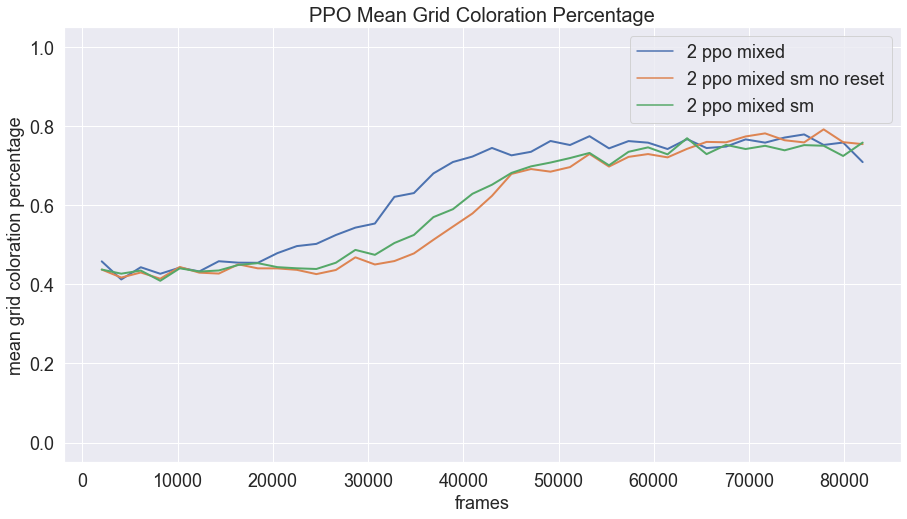

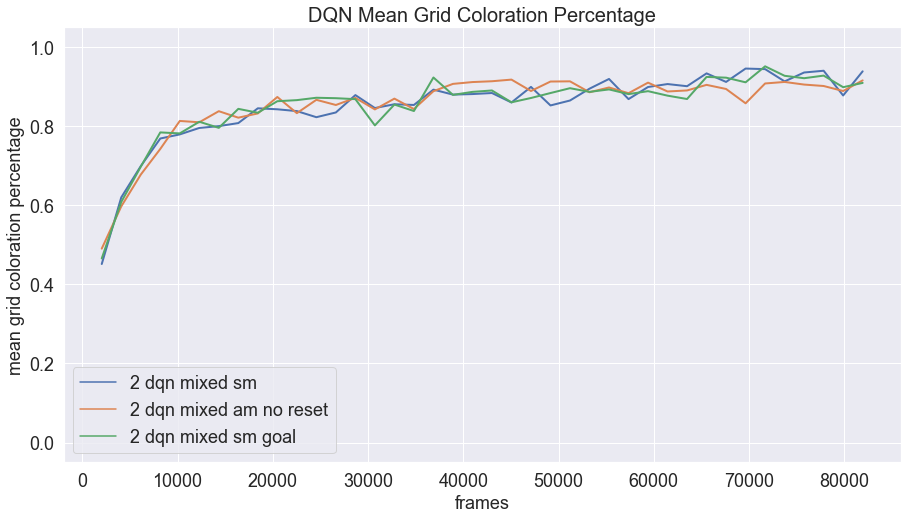

/opt/homebrew/Caskroom/miniforge/base/envs/python38/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


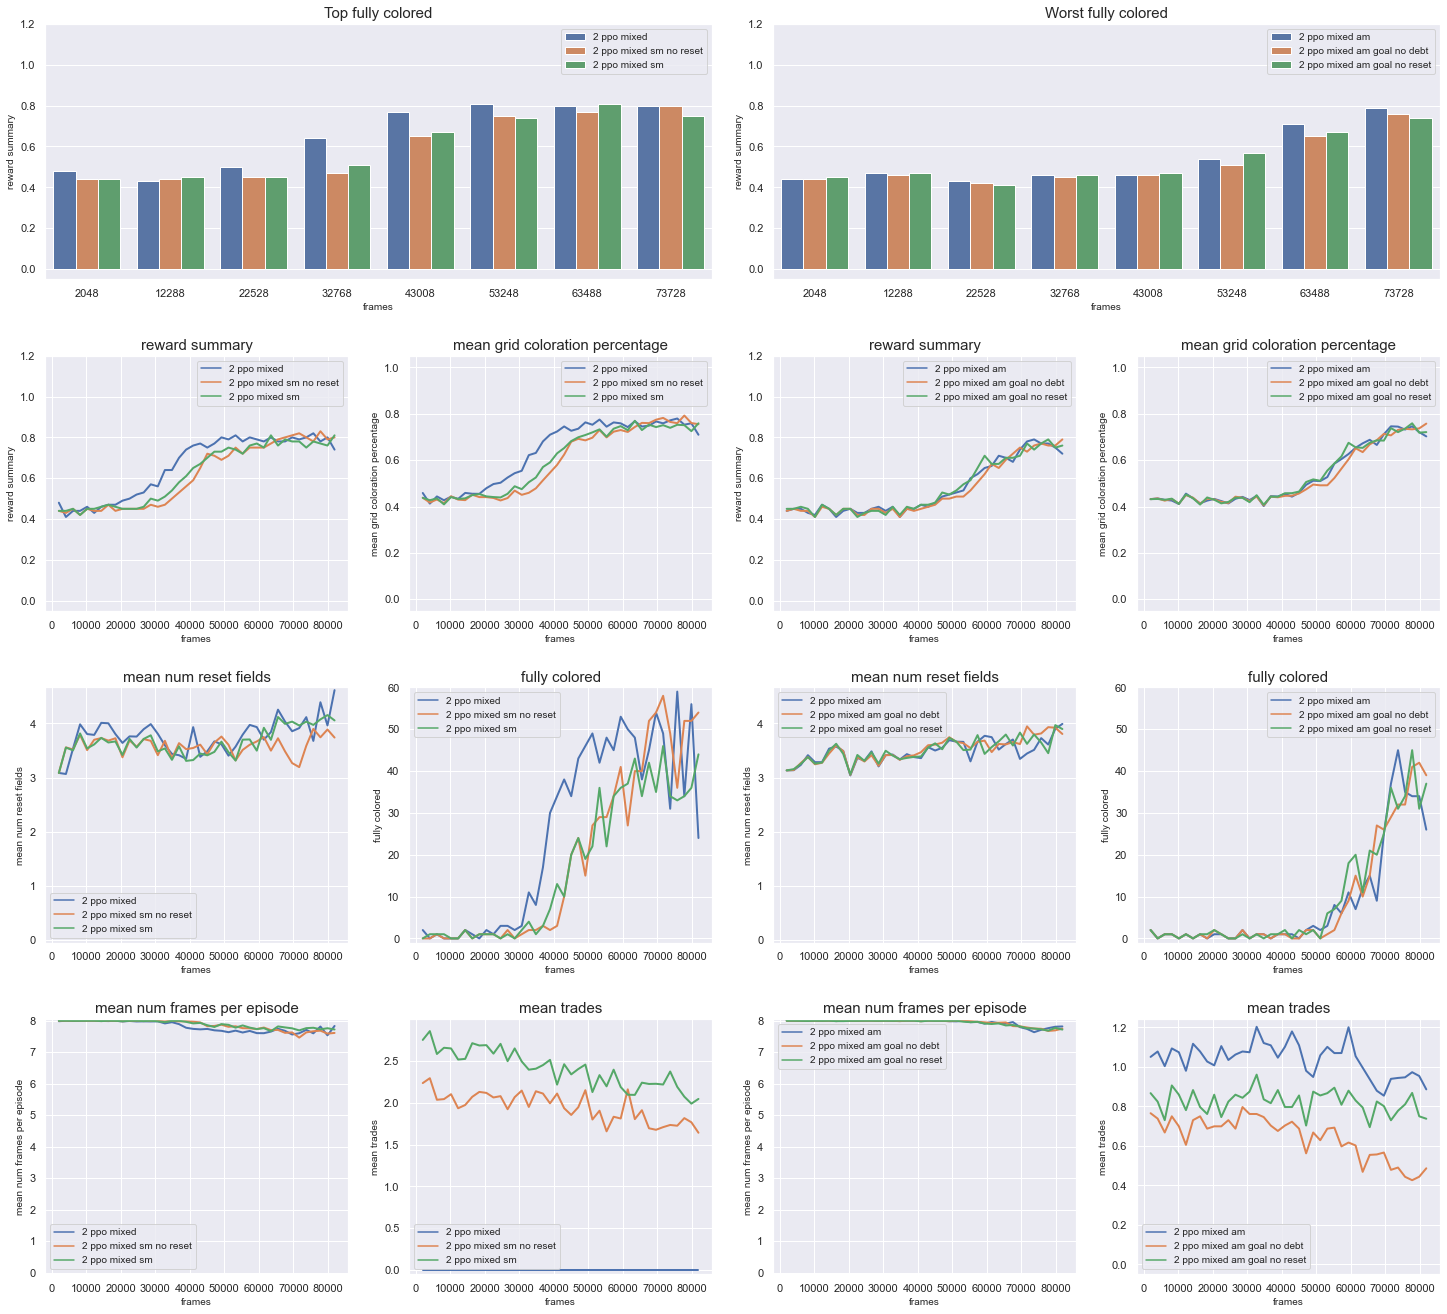

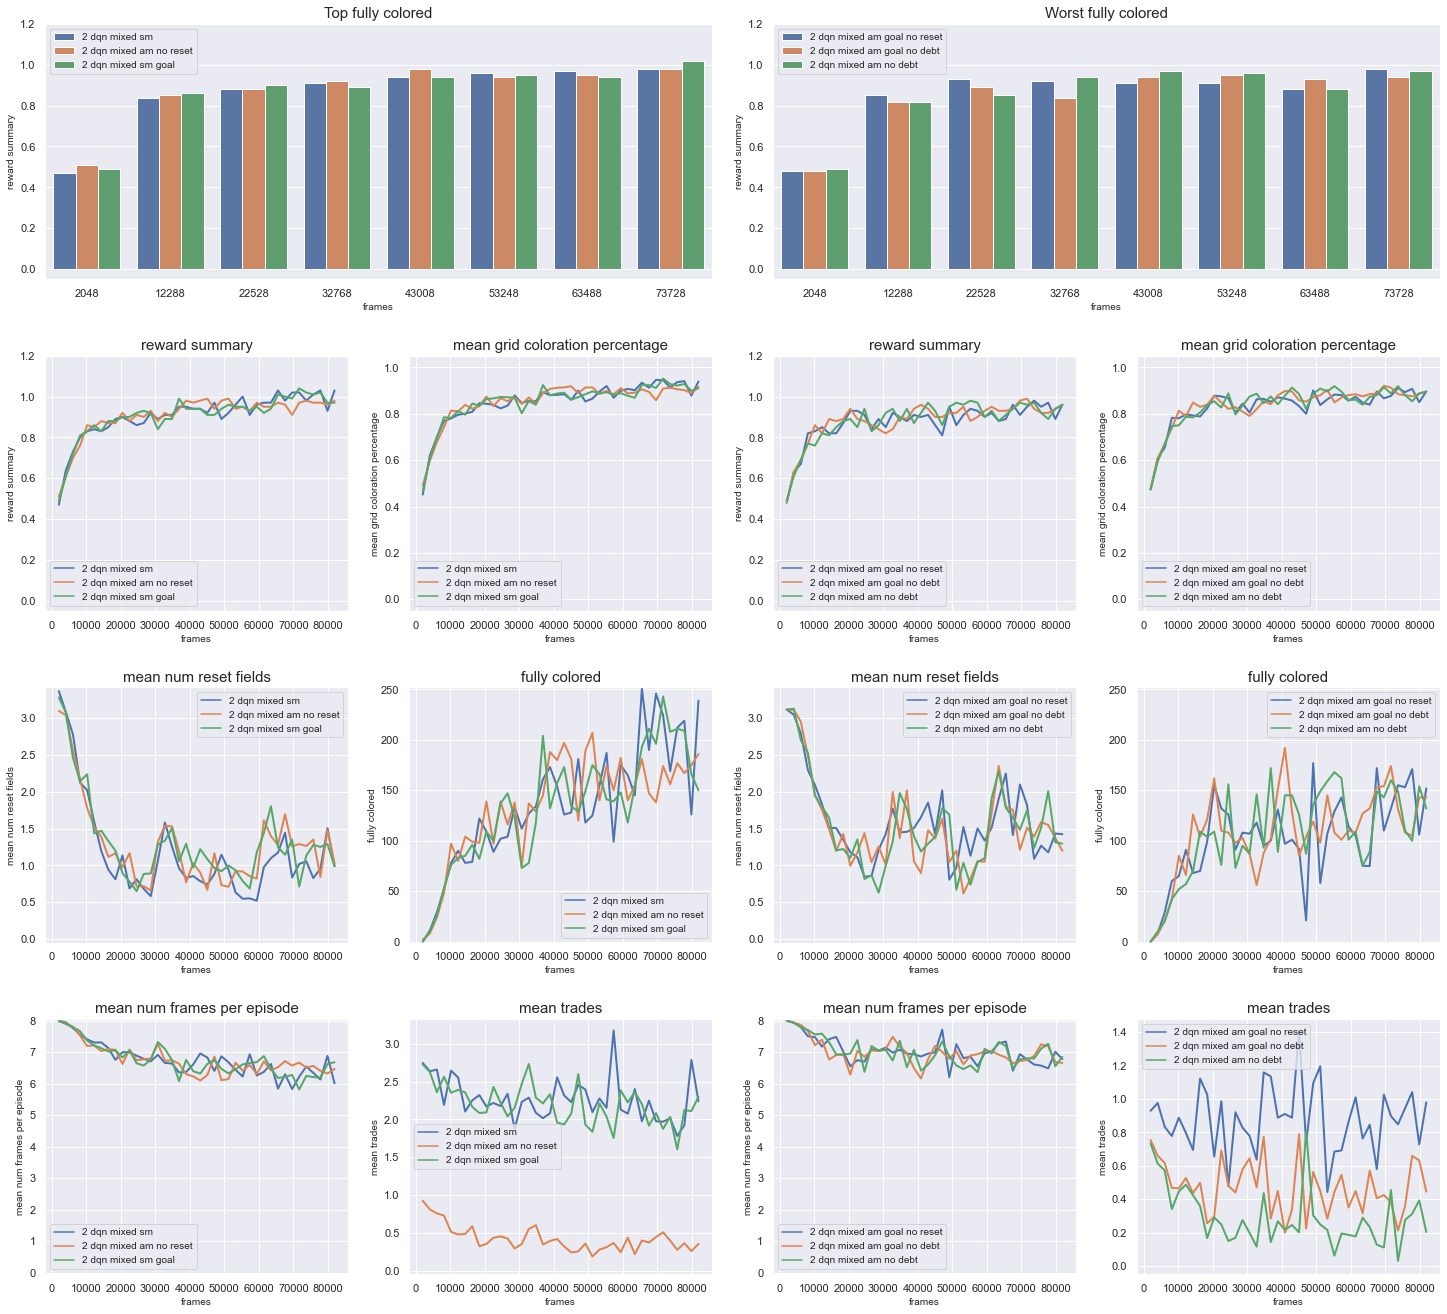

In [194]:
# only mixed
ppo_mixed_stats = get_stats(["fully_colored"], "2-ppo-mixed", 3, ["competitive"], print_table=True)
dqn_mixed_stats = get_stats(["fully_colored"], "2-dqn-mixed", 3, ["competitive"], print_table=True)


print_simple_plot(ppo_mixed_stats['Top fully colored'], "mean_grid_coloration_percentage", "PPO Mean Grid Coloration Percentage")
print_simple_plot(dqn_mixed_stats['Top fully colored'], "mean_grid_coloration_percentage", "DQN Mean Grid Coloration Percentage")

print_double_multiplot(ppo_mixed_stats)
print_double_multiplot(dqn_mixed_stats)

In [164]:
# only competitive
ppo_comp_stats = get_stats(["fully_colored"], "2-ppo-competitive", 3, [], print_table=True)
dqn_comp_stats = get_stats(["fully_colored"], "2-dqn-competitive", 3, [], print_table=True)
# print_double_multiplot(comp_stats)

+----------+---------------------------------+-------------------------------------+
| Position |        Top fully colored        |         Worst fully colored         |
+----------+---------------------------------+-------------------------------------+
|    1     |             3178.0              |                760.0                |
|          |        2 ppo competitive        |      2 ppo competitive am goal      |
|          |                                 |                                     |
|    2     |             2645.0              |                839.0                |
|          |  2 ppo competitive sm no reset  |  2 ppo competitive am goal no debt  |
|          |                                 |                                     |
|    3     |             2437.0              |                951.0                |
|          |       2 ppo competitive sm      |     2 ppo competitive am no debt    |
|          |                                 |                   

## Overall Top Runs

+----------+--------------------------------------+--------------------------+
| Position |          Top fully colored           |   Worst fully colored    |
+----------+--------------------------------------+--------------------------+
|    1     |               7877.0                 |          22.0            |
|          |  2 dqn competitive sm goal no reset  |  2 ppo sm goal no reset  |
|          |                                      |                          |
|    2     |               7842.0                 |          23.0            |
|          |         2 dqn competitive sm         |      2 ppo am goal       |
|          |                                      |                          |
|    3     |               7560.0                 |          23.0            |
|          |  2 dqn competitive am goal no debt   |  2 ppo am goal no reset  |
|          |                                      |                          |
|    4     |               7429.0                 | 

/opt/homebrew/Caskroom/miniforge/base/envs/python38/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


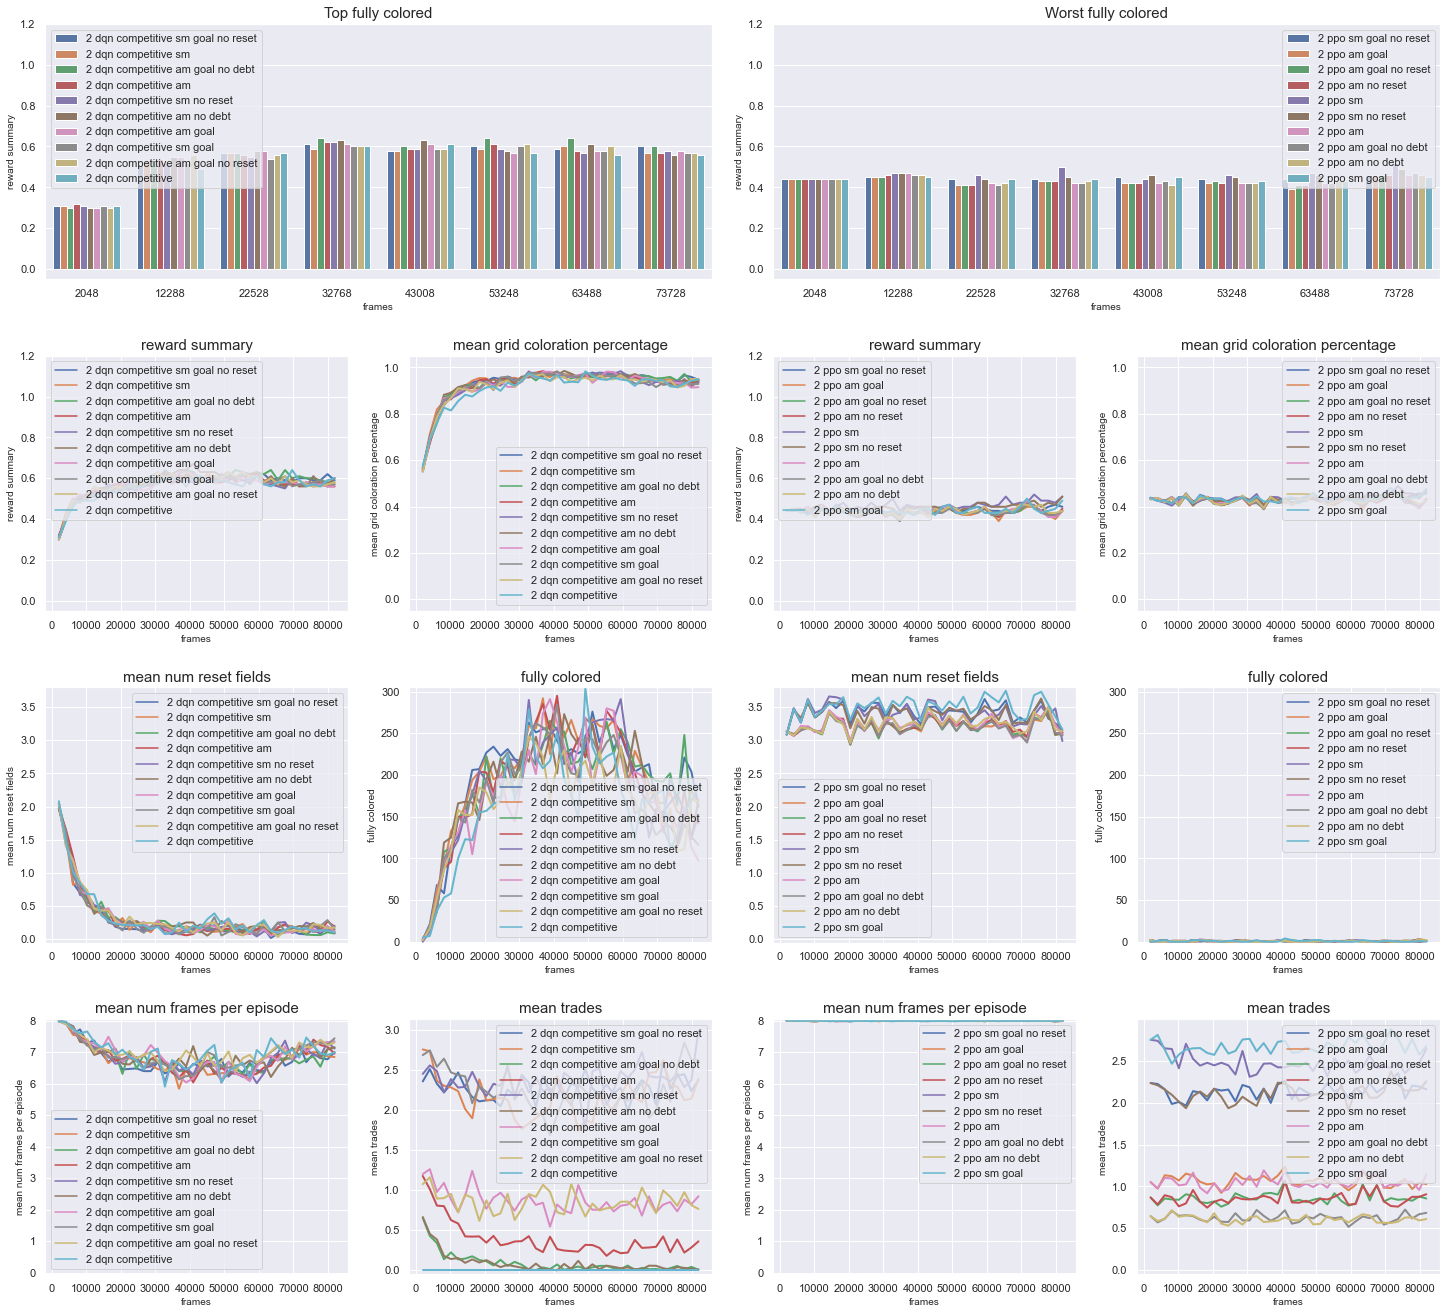

In [165]:
stats = get_stats(["fully_colored"], "2-", 10, print_table=True)
print_double_multiplot(stats)

In [166]:
# # without restrictive market settings (ignoring goal, no reset and no debt settings)

# # pool of 10 settings remain:
# # base settings: coop, mixed, competitive   -> + 3
# # 2 markets: am, sm                         -> + 6 (for each base setting)
# # and difference rewards                    -> + 1 = 10 

# restictive_markets = get_stats(["fully_colored"], "2-"+algo, 5, ["goal", "no-reset", "no-debt"], print_table=True)
# print_double_multiplot(restictive_markets)